In [1]:
import tools
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from scipy.signal import iirnotch, filtfilt, butter

F0 = 60.0  # Frequency to be removed from signal (Hz)
Q = 30.0  # Quality factor



In [2]:
def _bipolar_reference(data_arg):
    (n_time_samples, n_channels) = data_arg.shape
    # separate contact names
    leads = []
    contacts = []
    for i in data_arg.columns:
        if i in ['C3', 'C4', 'ECG1', 'ECG2']:
            n_channels = n_channels - 1
            continue

        M = re.match(r"(\D+)(\d+)", i)
        if M is None:
            n_channels = n_channels - 1
            continue
        leads.append(M.group(1).replace("EEG", "").strip())
        contacts.append(int(M.group(2)))

    leads_contacts = [f"{i}{j:02d}" for i, j in zip(leads, contacts)]
    col_names = []
    data_entries = []
    # find montage channel before
    for index in range(n_channels - 1):
        lead = leads[index]
        contact = contacts[index]

        next_lead_contact = f"{lead}{(contact + 1):02d}"

        try:
            next_index = leads_contacts.index(next_lead_contact)
        except ValueError:
            continue

        col_names.append(f"{leads_contacts[index]}-{leads_contacts[next_index]}")
        data_entries.append(data_arg.iloc[:, index] - data_arg.iloc[:, next_index])
    
    data_entries = np.array(data_entries).T
    bipolar_data = pd.DataFrame(data_entries, columns=col_names, index=data_arg.index)

    return bipolar_data


In [3]:
# username = 'pattnaik'
# pwd_bin_file = '/mnt/local/gdrive/public/USERS/pattnaik/pre-ictal-similarity/code/pat_ieeglogin.bin'

username = 'igvilla'
pwd_bin_file = '/gdrive/public/USERS/igvilla/igv_ieeglogin.bin'

###

# practice of a random new time:
# start_time_sec = 315961
# end_time_sec = 315961 + 60 

# practice of a random new time:
# iEEG_filename = 'HUP231_phaseII'
# start_time_usec = start_time_sec * 1e6
# end_time_usec = end_time_sec * 1e6

# practice of a random new time:
# iEEG_filename = 'HUP231_phaseII'
# start_time_usec = start_time_sec * 1e6
# end_time_usec = end_time_sec * 1e6

### 

# LB3_001_phaseII, seizure 1:
start_time_sec = 304819.92 - 60 # showing starting 1 minute before the seizure
end_time_sec = 304819.92 + 211.75 

# LB3_001_phaseII, seizure 1:
iEEG_filename = 'HUP225_phaseII'
start_time_usec = start_time_sec * 1e6
end_time_usec = end_time_sec * 1e6




In [4]:
data, fs = tools.get_iEEG_data(username, pwd_bin_file, iEEG_filename, start_time_usec, end_time_usec, select_electrodes=np.arange(50))



In [5]:
start_time_usec, end_time_usec

(304759920000.0, 305031670000.0)

In [6]:
# extract dims
(n_samples, n_channels) = data.shape

# set time array
t_sec = np.linspace(start_time_sec, end_time_sec, n_samples)

# remove 60Hz noise
b, a = iirnotch(F0, Q, fs)
signal_filt = filtfilt(b, a, data, axis=0)

# bandpass between 1 and 120Hz
bandpass_b, bandpass_a = butter(3, [1, 120], btype='bandpass', fs=fs)
signal_filt = filtfilt(bandpass_b, bandpass_a, signal_filt, axis=0)

# format resulting data into pandas DataFrame
signal_filt = pd.DataFrame(signal_filt, columns=data.columns)
signal_filt.index = pd.to_timedelta(t_sec, unit="S")

signal_ref = _bipolar_reference(signal_filt)

In [7]:
np.size(signal_ref)

9461248

In [8]:
signal_ref

,RA01-RA02,RA02-RA03,RA03-RA04,RA04-RA05,RA05-RA06,RA06-RA07,RA07-RA08,RA08-RA09,RA09-RA10,RA10-RA11,...,RC05-RC06,RC06-RC07,RC07-RC08,RC08-RC09,RC09-RC10,RC10-RC11,RC11-RC12,RD01-RD02,RD02-RD03,RD03-RD04
3 days 12:39:19.920000,9.395256,-9.639325,-0.636841,0.184654,7.159241,-2.440376,4.986895,-5.130237,0.342475,3.214956,...,-7.390684,-2.738988,-34.490098,-13.627029,52.333915,-10.686017,-0.065105,-1.284087,12.362885,-1.159529
3 days 12:39:19.920976566,14.178975,-12.739874,-0.668000,-1.000249,7.895948,-2.084216,3.534110,-5.414916,2.210023,1.930821,...,-3.607937,-3.196809,-35.834338,-13.886030,51.538297,-11.932632,-1.630973,-3.012313,14.778074,2.369448
3 days 12:39:19.921953132,17.681463,-14.790137,-0.492145,-2.116050,8.277527,-1.737952,2.537075,-5.748752,3.594222,0.858954,...,0.151004,-3.545803,-37.862705,-14.791404,52.165618,-13.387928,-3.312673,-4.776338,17.610410,5.887832
3 days 12:39:19.922929698,18.792528,-14.814903,-0.106287,-3.028984,8.149485,-1.461673,2.368562,-6.215791,4.204622,0.128926,...,3.717917,-3.684547,-40.856634,-16.740516,55.071514,-15.221534,-5.188990,-6.534744,21.102221,9.303716
3 days 12:39:19.923906264,16.856468,-12.166271,0.262777,-3.553983,7.604202,-1.333295,3.243294,-6.938288,4.031685,-0.254593,...,6.783512,-3.546346,-44.592090,-19.746605,60.337696,-17.553724,-7.282182,-8.153291,25.219658,12.454557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3 days 12:43:51.666093736,-153.232542,124.350240,-27.343891,25.860476,15.097962,-8.506700,-17.767269,5.155785,4.887831,22.276472,...,5.814757,2.011400,-60.330627,-51.143088,77.567623,18.079785,-7.592698,-3.957997,16.827201,9.179131
3 days 12:43:51.667070302,-236.452997,209.007479,-27.915638,25.236797,18.940924,-10.248203,-18.287124,4.779822,4.622366,21.597474,...,5.898564,1.778083,-57.653627,-49.019258,73.735719,17.462313,-7.308393,-3.625612,16.211275,8.889386
3 days 12:43:51.668046868,-288.972122,265.480969,-26.060711,23.980821,19.024528,-11.081176,-16.706287,4.645070,4.291359,20.795554,...,6.686660,1.382532,-55.930896,-47.407739,70.288924,16.997900,-7.029066,-3.470105,15.813471,9.101746
3 days 12:43:51.669023434,-311.020439,293.849154,-22.113438,22.200693,15.627707,-10.844095,-13.518873,4.754136,3.978352,19.864715,...,8.038463,0.857127,-55.145257,-46.235729,67.230910,16.699484,-6.736159,-3.530804,15.596875,9.683623


In [9]:
signal_ref.to_hdf(f"../data/eeg_pt-{iEEG_filename}_start-{start_time_sec}_end-{end_time_sec}.h5", key='ieeg')

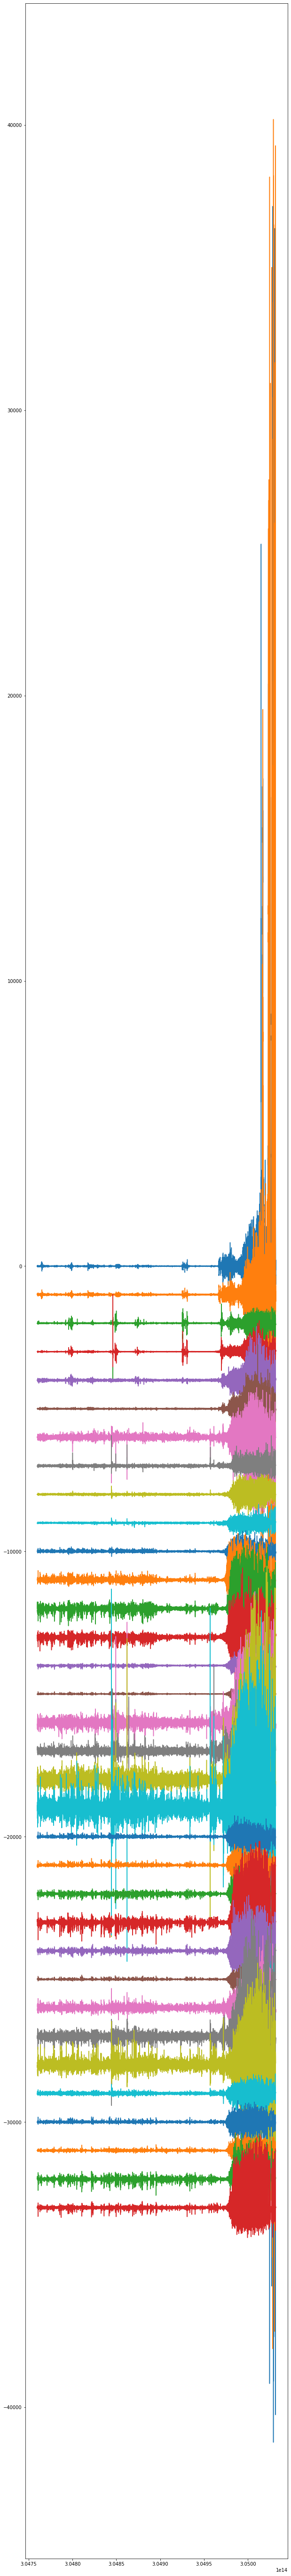

In [10]:
plt.figure(figsize=(10, 100)); plt.plot(signal_ref.iloc[:, 0:34] + np.arange(34)*-1000)